In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import magnetics

from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

write_output = False

### Adding a Topography

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = -15*np.exp(-(x_topo**2 + y_topo**2) / 60**2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

### Setting up a Survey and Inducing field parameters 

In [3]:
x = np.linspace(-130.0, 130.0, 17)
y = np.linspace(-130.0, 130.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10 # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

components = ["tmi"]

receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

inclination = 47.5
declination = 6.42
strength = 48843.8

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=strength,
    inclination=inclination,
    declination=declination,
)

survey = magnetics.survey.Survey(source_field)

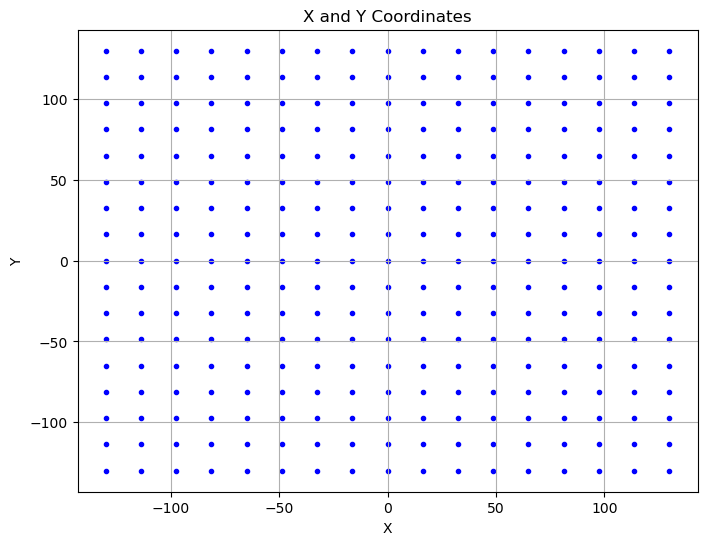

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='b', marker='.')
plt.title('X and Y Coordinates')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

### Setting up a Tensor mesh

In [5]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

### Defining a Susceptibility Model

In [6]:
background_susceptibility = 1e-4
mineralized_zone = 0.15
Dolerite_dyke = 0.03

ind_active = active_from_xyz(mesh, xyz_topo)

nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

model = background_susceptibility * np.ones(ind_active.sum())

xp = np.kron(np.ones((2)), [90.0, 45.0, -100.0, -65.0])
yp = np.kron([-100.0, 100.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-120.0, -120.0, -20, -20])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  
model[ind_polygon] = mineralized_zone

xp = np.kron(np.ones((2)), [100.0, 90.0, 40.0, 25.0])
yp = np.kron([-100.0, 100.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-130.0, -130.0, -20.0, -20.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active] 
model[ind_polygon] = Dolerite_dyke

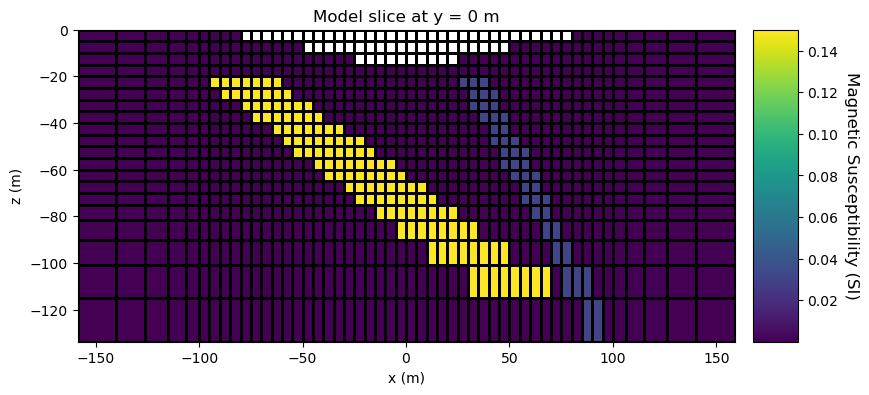

In [7]:
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

plt.show()

### Simulation: TMI Data for a Susceptibility Model

In [8]:
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    ind_active=ind_active,
)

In [9]:
dpred = simulation.dpred(model)

### Assign Uncertainty

In [10]:
relative_error=0.02

np.random.seed(1)

noisy_data = (
    dpred + 
    np.random.randn(len(dpred)) * relative_error * np.abs(dpred))

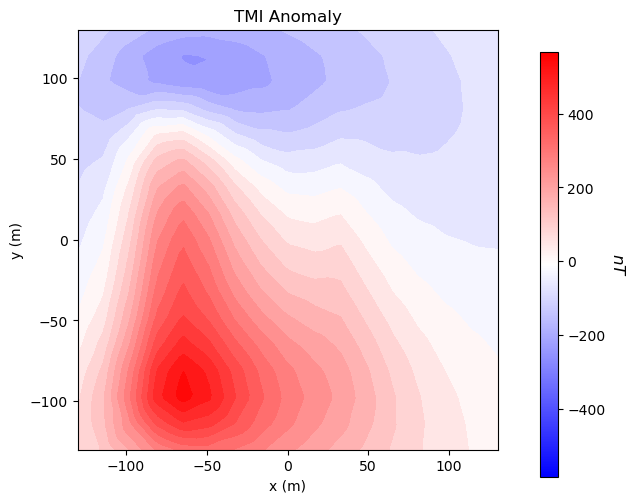

In [11]:
fig = plt.figure(figsize=(6, 5))
v_max = np.max(np.abs(noisy_data))

ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.95])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(noisy_data)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

## Inversion for Total Magnetic Intensity Data on a Tensor Mesh

### Building a Reference model

In [12]:
background_susceptibility = 1e-4
Cu_deposit_AveSus= 0.09
Dolerite_dyke_AveSus = 0.03

ind_active1 = active_from_xyz(mesh, xyz_topo)

nC1= int(ind_active1.sum())
model_map1 = maps.IdentityMap(nP=nC1)

ref_model = background_susceptibility * np.ones(ind_active1.sum())

xp1 = np.kron(np.ones((2)), [80.0, 55.0, -90.0, -65.0])
yp1 = np.kron([-100.0, 100.0], np.ones((4)))
zp1 = np.kron(np.ones((2)), [-100.0, -100.0, -20, -20])
xyz_pts1 = np.c_[mkvc(xp1), mkvc(yp1), mkvc(zp1)]
ind_polygon1 = model_builder.get_indices_polygon(mesh, xyz_pts1)
ind_polygon1 = ind_polygon1[ind_active1]  
ref_model[ind_polygon1] = Cu_deposit_AveSus

xp1 = np.kron(np.ones((2)), [95.0, 90.0, 40.0, 30.0])
yp1 = np.kron([-20.0, 20.0], np.ones((4)))
zp1 = np.kron(np.ones((2)), [-90.0, -90.0, -20.0, -20.0])
xyz_pts1 = np.c_[mkvc(xp1), mkvc(yp1), mkvc(zp1)]
ind_polygon1 = model_builder.get_indices_polygon(mesh, xyz_pts1)
ind_polygon1= ind_polygon1[ind_active1] 
ref_model[ind_polygon1] = Dolerite_dyke_AveSus 

In [13]:
starting_model = background_susceptibility * np.ones(nC)

### Defining the Data

In [14]:
data_object = data.Data(survey, dobs=noisy_data, standard_deviation=relative_error)

### Define Inverse Problem

In [15]:
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    active_cells=ind_active,
    mapping=model_map,
     gradient_type="total",
    reference_model=ref_model
   
)

# Define sparse and blocky norms p, qx, qy, qz
reg.norms = [1e-4, 0, 0, 2]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=20, lower=0.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

### Define Inversion Directives

In [16]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e2)

# Options for outputting recovered models and predicted data for each beta.
save = directives.SaveOutputDictEveryIteration()

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    coolEpsFact=1.5,
    beta_tol=1e-2,
)

# Updating the preconditioner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save,
    update_IRLS,
    update_jacobi,
]

### Running the Inversion

In [17]:
inv = inversion.BaseInversion(inv_prob, directives_list)

# Print target misfit to compare with convergence
# print("Target misfit is " + str(target_misfit.target))

# Run the inversion
recovered_model = inv.run(starting_model)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.36e+09  1.26e+10  2.68e+01  7.61e+10    1.93e+02      0              
   1  1.18e+09  3.66e+09  1.12e+01  1.69e+10    1.96e+02      0              
   2  5.91e+08  2.53e+09  1.19e+01  9.54e+09    1.93e+02      0   Skip BFGS  
   3  2.96e+08  1.54e+09  1.31e+01  5.40e+09    1.92e+02      0   Skip BFGS  
   4  1.48e+08  7.92e+08  1.48e+01  2.98e+09    1.90e+02      0   Skip BFGS  
   5  7.39e+07  3.63e+08  1.68e+01  1.61e+09    1.88e+02      0   Skip BFGS  
   6  3.70e+07  1.55e+08  1.88e+01  8.49e+08    1.85e+02     

### Plotting Tikhonov_curve

In [18]:
def plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=None, iteration=None, ax=None, ylims=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    if ylims is None:
        ylims = [None, None, None]  # Default to None if not provided

    ax[0].plot(beta_values, phi_d)
    ax[1].plot(beta_values, phi_m)
    ax[2].plot(phi_m, phi_d)

    if phid_star is not None: 
        ax[0].plot(beta_values, np.ones_like(beta_values) * phid_star, "--k")
        ax[2].plot(phi_m, np.ones_like(beta_values) * phid_star, "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")
    
    if iteration is not None: 
        ax[0].plot(beta_values[iteration], phi_d[iteration], "C3o")
        ax[1].plot(beta_values[iteration], phi_m[iteration], "C3o")
        ax[2].plot(phi_m[iteration], phi_d[iteration], "C3o")

    for i, a in enumerate(ax[:2]):
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
        if ylims[i] is not None:
            a.set_ylim(ylims[i])
            
    if ylims[2] is not None:
        ax[2].set_ylim(ylims[2])
        
    plt.tight_layout()
    
    return ax

In [19]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

In [20]:
def plot_model_slice_with_colorbar(
    mesh, ind_active, recovered_model, figsize=(9, 4)
):
    fig = plt.figure(figsize=figsize)
    
    plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
    
    ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
    mesh.plot_slice(
        plotting_map * recovered_model,
        normal="Y",
        ax=ax1,
        ind=int(mesh.shape_cells[1] / 2),
        grid=True,
        clim=(np.min(recovered_model), np.max(recovered_model)),
    )
    ax1.set_title("Model slice at y = 0 m")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("z (m)")

    ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
    norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
    cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
    cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

    plt.show()

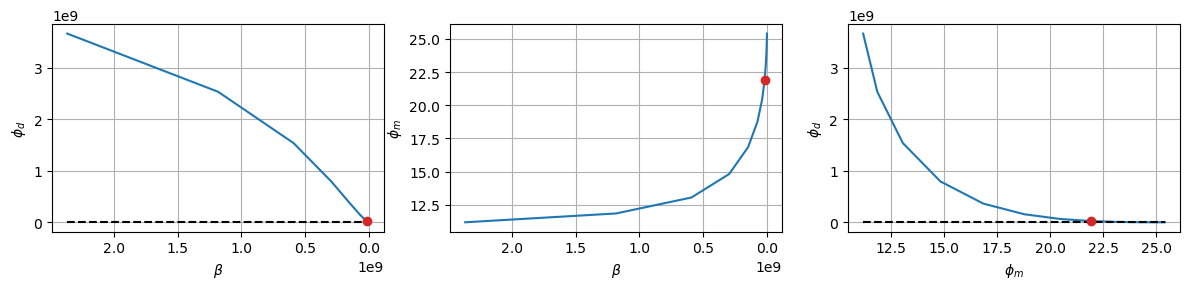

In [21]:
iteration = 7
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=1)

### Recovered Model

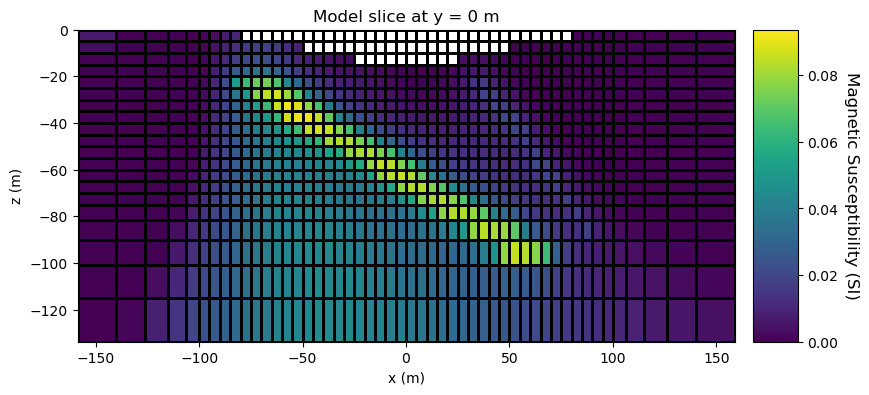

In [22]:
iteration =7

plot_model_slice_with_colorbar(
    mesh, ind_active, models[iteration],
)

### Plotting Predicted Data and Misfit

In [23]:
dpred_i = simulation.dpred(models[iteration])

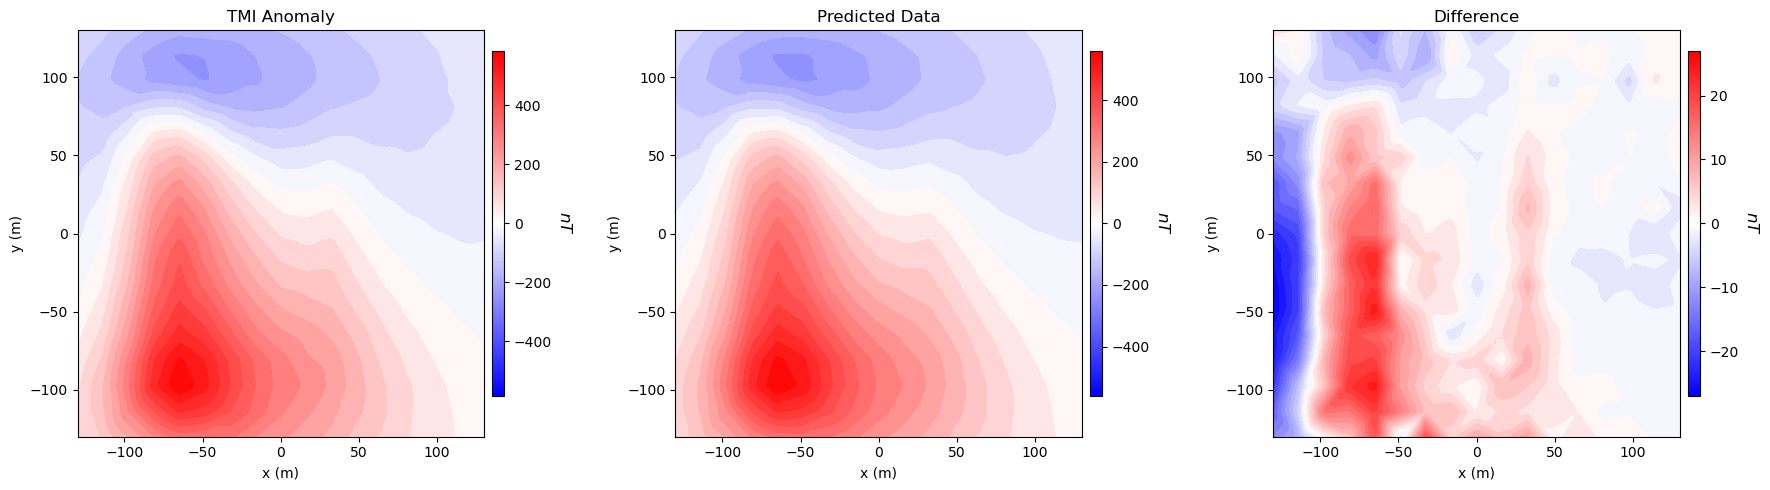

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a single figure with three subplots

# Plot 1: TMI Anomaly
v_max1 = np.max(np.abs(noisy_data))
plot2Ddata(
    receiver_list[0].locations,
    noisy_data,
    ax=axes[0],
    ncontour=30,
    clim=(-v_max1, v_max1),
    contourOpts={"cmap": "bwr"},
)
axes[0].set_title("TMI Anomaly")
axes[0].set_xlabel("x (m)")
axes[0].set_ylabel("y (m)")

# Colorbar for Plot 1
norm1 = mpl.colors.Normalize(vmin=-v_max1, vmax=v_max1)
cbar1 = mpl.colorbar.ColorbarBase(
    axes[0].inset_axes([1.02, 0.1, 0.03, 0.85]),  # Adjust position as needed
    norm=norm1,
    orientation="vertical",
    cmap=mpl.cm.bwr,
)
cbar1.set_label("$nT$", rotation=270, labelpad=15, size=12)

# Plot 2: Predicted Data
v_max2 = np.max(np.abs(dpred_i))
plot2Ddata(
    receiver_list[0].locations,
    dpred_i,
    ax=axes[1],
    ncontour=30,
    clim=(-v_max2, v_max2),
    contourOpts={"cmap": "bwr"},
)
axes[1].set_title("Predicted Data")
axes[1].set_xlabel("x (m)")
axes[1].set_ylabel("y (m)")

# Colorbar for Plot 2
norm2 = mpl.colors.Normalize(vmin=-v_max2, vmax=v_max2)
cbar2 = mpl.colorbar.ColorbarBase(
    axes[1].inset_axes([1.02, 0.1, 0.03, 0.85]), 
    norm=norm2,
    orientation="vertical",
    cmap=mpl.cm.bwr,
)
cbar2.set_label("$nT$", rotation=270, labelpad=15, size=12)

# Plot 3: Difference between Noisy Data and Predicted Data
v_max3 = np.max(np.abs(noisy_data - dpred_i))
plot2Ddata(
    receiver_list[0].locations,
    noisy_data - dpred_i,
    ax=axes[2],
    ncontour=30,
    clim=(-v_max3, v_max3),
    contourOpts={"cmap": "bwr"},
)
axes[2].set_title("Difference")
axes[2].set_xlabel("x (m)")
axes[2].set_ylabel("y (m)")

# Colorbar for Plot 3
norm3 = mpl.colors.Normalize(vmin=-v_max3, vmax=v_max3)
cbar3 = mpl.colorbar.ColorbarBase(
    axes[2].inset_axes([1.02, 0.1, 0.03, 0.85]),  
    norm=norm3,
    orientation="vertical",
    cmap=mpl.cm.bwr,
)
cbar3.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.tight_layout()